## CNN Model with Image Augmentation: Detecting Glaucoma
This notebook goes into detail about how we imported images, implemented image augmentation, structured our Convolutional Neural Network model, and analyzed our results. It also incudes sections on Feature Maps and Filters at the end of the notebook. 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Imports 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report



In [ ]:
# setting a random seed for reproducibility
np.random.seed(42)

### Reading in image data as X and y
This code assumes there is a folder with subfolders for each eye condition, and that the images in the subfolders have already been resized to 512x512 using the function in the [image_preprocessing notebook](../proj5/image_preprocessing.ipynb).

In [ ]:
# specify the path with the subfolders of cleaned eye images (each subfolder is an eye condition)
clean_path = '/content/drive/MyDrive/cleaned_eye_images/'

# the target y is the eye condition 
# make a dictionary of eye conditions and integers because y needs to be a number, not a string
# setting the condition to be 1 so that 'positive' results mean the eye has the condition
condition_dict = {'glaucoma':1, 'normal': 0}

# make empty lists for X and y
X=[]
y=[]

# iterate through each subfolder (= condition)
for condition in os.listdir(clean_path):
    
    # make sure the subfolder is actually the name of a condition (e.g., not 'DS_Store')
    if condition in condition_dict.keys():
        
        # allows you to specify how many images to collect from each folder
        # this allows the final number to be divisible by the desired batch size (necessary when using on-the-fly image augmentation)
        number=0
        total_num = 404
        
        # iterate through each image file in the subfolder
        for file in os.listdir(clean_path+condition):
            
            if number < total_num:
            
            # added a try/except so that DS_Store files don't trip an error
                try:
                    # load the image file
                    image = load_img(clean_path+condition+'/'+file)
                
                    # convert the image to an array and normalize it by dividing by 255
                    # now normalizing with the ImageGenerator instead
                    #image_arr = img_to_array(image) / 255
                
                    image_arr = img_to_array(image)
                
                    # add the image array to X
                    X.append(image_arr)
                
                    # use the condition_dict to add the right number to y that corresponds to the eye condition
                    y.append(condition_dict[condition])
                    
                    number+=1
                
                except:
                    # if processing the file doesn't work, skip it and continue to the next file
                    continue

In [ ]:
# change X and y into numpy arrays
X = np.array(X)
y = np.array(y)

In [ ]:
# checking the shape of X
# there are 704 512x512 images with 3 channels (RGB)
X.shape

(704, 512, 512, 3)

In [ ]:
# y matches the number of images in X
y.shape

(704,)

### Baseline Model
Our dataset is slightly unevenly distributed between normal eyes and eyes with glaucoma, and the model needs to make correct predictions more than 57.4% of the time to beat the baseline accuracy.

In [ ]:
print(f'There are {len(y)-y.sum()} non-diseased eye images and {y.sum()} images of eyes with glaucoma in the dataset.')

# Since y is binary with values of 0 and 1, the baseline accuracy can be found by summing y and dividing by the length of y
# The baseline accuracy is the higher of this value and 1 - this value
# rounding the numbers to 3 places to make the formatting nicer
print(f'This gives a baseline accuracy of {round(np.array([(y.sum() / len(y)),(1-(y.sum()/len(y)))]).max(), 3)}')

There are 300 non-diseased eye images and 404 images of eyes with glaucoma in the dataset.
This gives a baseline accuracy of 0.574


### Train-Test Split
Split the data into training and testing sets in the usual way, making sure to stratify and to set the desired testing dataset size

In [ ]:
# regular train-test-split 
# no need for StandardScaler because the images have already been normalized

# changed test_size to 128 so test and train sizes are both divisible by 32, the batch_size
# to use with image augmentation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=128, random_state=42, stratify=y)

In [ ]:
# checking the shape of X_train. Looks good.
X_train.shape

(576, 512, 512, 3)

In [ ]:
X_test.shape

(128, 512, 512, 3)

### Image Augmentation 

Image augmentation refers to increasing the number of images in the training set by making small changes to the images that are already there. These changes -- such as flipping an image, shifting it a few pixels, or adjusting the brightness -- will give the model 'new' training data. 

Image augmentation allows you to make a good CNN model even if you have limited data, and helps prevent overfitting. [This site](https://stepup.ai/train_data_augmentation_keras/) gives a good overview of how image augmentation works, and especially explains how this technique limits overfitting.

The transformations applied to the images need to preserve the true features of the original image and should also represent differences that would be likely in new data, as [this site](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/) explains in detail. For example, horizontally flipping a fundus image of an eye makes sense, but vertically flipping it does not. 

There are 2 main ways to use the Keras ImageDataGenerator for image augmentation -- by saving all the new images as a massive new training set, or by generating new images on the fly during model fitting. The second way is preferred since saving the images takes a lot of memory. [This site](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/) provides excellent guidance on image augmentation techniques and explains both ways of using the generator, on the fly and to save the images.

As explained [here](https://stackoverflow.com/questions/51748514/does-imagedatagenerator-add-more-images-to-my-dataset), when using ImageDataGenerator during model fitting, each epoch will actually train on a slightly different set of images generated from the training data. Each training image will be randomly transformed and trained on one time during each epoch, so the final number of images that the model analyzes will be equal to the number of training images multiplied by the number of epochs.



In [ ]:
# make an ImageDataGenerator object for both the training and test data, but only apply random image transformations
# to the training data

# running the test data through the same generator, minus the transformations, ensures the images receive identical
# preprocessing. We intially didn't do this, and the model got below 25% accuracy on the test data

# we followed the example of training and testing generators given in the code about halfway down this website--
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

# separately, this website explains that the default brightness is 1, values lower than that will darken the image, and values higher will brighten it --
# https://www.studytonight.com/post/random-brightness-image-augmentation-keras-imagedatagenerator

image_generator_train = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, rotation_range=30, brightness_range=(.8,1.2))

image_generator_test = ImageDataGenerator(rescale=1.0/255.0)

# fit the training data on the training generator
image_generator_train.fit(X_train)

# fitting the test data on the testing generator isn't necessary since it's just re-scaling

In [ ]:
X_train.shape

(576, 512, 512, 3)

In [ ]:
X_test.shape

(128, 512, 512, 3)

### Building the CNN Model

This is a feed-forward fully-connected Sequential model with 4 convolutional layers, 4 corresponding pooling layers, a flattening layer, 2 dense layers, and an output layer. Each convolutional layer uses a 3x3 filter size, and each pooling layer uses a 2x2 grid and equal stride.

We started with a small number of features in our first convolutional layer and increased the number at subsequent layers. We found that this is recommended because a model will find the smaller number of basic features first and then build these up into more complex larger numbers of features. For example, see the section on Deep convolutional networks [here](https://www.jeremyjordan.me/convolutional-neural-networks/)

There is also a good discussion [here](https://stats.stackexchange.com/questions/222883/why-are-neural-networks-becoming-deeper-but-not-wider) regarding making neural networks deeper (with more layers) instead of wider (with more features / neurons) because a deeper network is better at generalizing to new data. For computing efficiency, we have limited our model to 12 layers. One area of future research would be to add more layers and compare performance to the current model.

In [ ]:
# Instantiate a Sequential model (that will process each layer sequentially)
model = Sequential()

In [ ]:
# add a Convolutional 2D layer that will create 16 3x3 filters to detect image features

# the input shape is 512x512 pixels with 3 channels (RGB)
# we chose 512x512 because we wanted smaller files, but didn't want to lose too much data by shrinking them too much
# many of the original image files were much bigger (e.g., 2464×1632, 3GB)
# in the CNN lesson, images were scaled to 256x256, but they weren't medical images, and that seemed too small
# 512x512 is double the size from the lesson
# also, one of the kaggle datasets included preprocessed images which had been resized to 512x512
# we decided to try this image size 

# using relu (rectified linear function) activation, which returns positive output directly and returns 0 for negative output

model.add(Conv2D(16, (3,3), activation='relu', input_shape=(512,512,3)))

In [ ]:
# add a MaxPooling 2D layer that will take the maximum value in every 2x2 grid (with a stride defaulting to the pool_size)
# this effectively cuts the dimensions of the data in half, and helps get rid of noise caused by small variations in the image

model.add(MaxPooling2D(pool_size=(2,2)))

In [ ]:
# add more convolutional layers (with max pooling between each one) 

# increasing filters to 32
# input shape is only needed for the first layer above
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

# increasing filters to 64
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

In [ ]:
# add a flatten layer to bridge between the convolutional layers and the dense layers
model.add(Flatten())

In [ ]:
# the dense layers analyze the features that were identified in the convolutional layers 
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))

In [ ]:
# add the output layer
# if there are multiple classes (not binary), change the nodes to the number of classes and use softmax activation
# if it's binary, use sigmoid activation
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# compile the model
# if multiclass, use categorical_crossentropy 
# if binary, use binary_crossentropy
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

### Fitting the Model

We fit the model on X_train and y_train using the image generator object created above for image augmentation. Validation data similarly comes from X_test and y_test via the image generator test object. Steps per epoch is set to the length of X_train divided by the batch size of 32 to conform to the requirements of using an image generator object. There are 30 possible epochs, but we added early stopping to end training when the validation loss levels out.

In [ ]:
# adding early stopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=.01, patience=5, verbose=1, mode='auto')


In [ ]:
# fit the model and save it as h so the accuracy and loss scores for each epoch can be visualized
# batch size is the number of images processed before updating the metrics
# epochs is the number of times the model goes through the entire dataset

# when using the image augmentation generator, batch size needs to be divisible by the number of images in X_train

h = model.fit(image_generator_train.flow(X_train, y_train, batch_size=32, seed=42), validation_data=(image_generator_test.flow(X_test, y_test, batch_size=32, seed=42)), steps_per_epoch=len(X_train)/32, epochs=30, callbacks=[early_stop])

Epoch 1/30
18/18 [==============================] - 55s 2s/step - loss: 0.6299 - accuracy: 0.6771 - val_loss: 0.3478 - val_accuracy: 0.8359
Epoch 2/30
18/18 [==============================] - 42s 2s/step - loss: 0.3948 - accuracy: 0.8316 - val_loss: 0.3220 - val_accuracy: 0.8750
Epoch 3/30
18/18 [==============================] - 42s 2s/step - loss: 0.3519 - accuracy: 0.8559 - val_loss: 0.2880 - val_accuracy: 0.8594
Epoch 4/30
18/18 [==============================] - 42s 2s/step - loss: 0.3686 - accuracy: 0.8333 - val_loss: 0.2942 - val_accuracy: 0.8672
Epoch 5/30
18/18 [==============================] - 39s 2s/step - loss: 0.3597 - accuracy: 0.8368 - val_loss: 0.2909 - val_accuracy: 0.8672
Epoch 6/30
18/18 [==============================] - 38s 2s/step - loss: 0.3308 - accuracy: 0.8542 - val_loss: 0.2864 - val_accuracy: 0.8828
Epoch 7/30
18/18 [==============================] - 38s 2s/step - loss: 0.3339 - accuracy: 0.8507 - val_loss: 0.2947 - val_accuracy: 0.8750
Epoch 8/30
18/18 [==

### Saving the Model
The model can be saved, allowing it to be used in a Flask app or for it to be re-loaded and trained with additional images later

In [ ]:
# code to save the model as an h5 file so that it can be used in Flask

# however, h5 files are huge, so we're commenting out the code so it doesn't run again by accident
model.save("/content/drive/MyDrive/FINAL MODELS/GLAUCOMA/glaucoma_model.h5")

### Visualizing the accuracy and loss scores for each epoch

Visualizing the accuracy and loss scores for each epoch shows how the model reached what is likely close to the best performance it could achieve given the model architecture and limited training data.

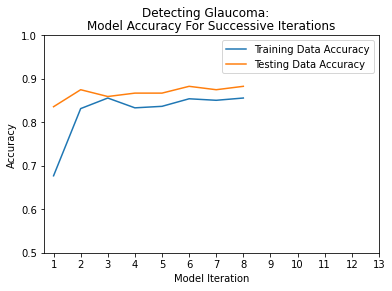

In [ ]:
# plot the training and testing accuracy scores with the appropriate labels
plt.plot(h.history['accuracy'], label='Training Data Accuracy')
plt.plot(h.history['val_accuracy'], label='Testing Data Accuracy')

# add titles and labels
plt.title('Model Accuracy For Successive Iterations')
plt.suptitle('Detecting Glaucoma:')
plt.xlabel('Model Iteration')
plt.xticks(ticks=range(0,13), labels=range(1,14))
plt.ylabel('Accuracy')

# set the y-axis range to .5 to 1 (i.e., a range of 50% to 100% accuracy)
plt.ylim(.5,1)

# include a legend
plt.legend()

# save the image as a jpg file
# plt.savefig('../presentation/model_performance_images/glauc_accuracy.jpg');

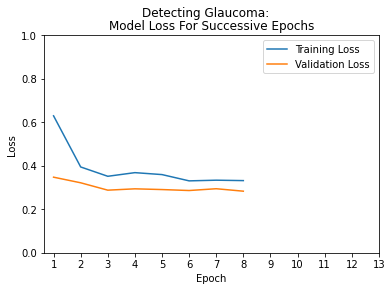

In [ ]:
# plot the training and testing loss scores
plt.plot(h.history['loss'], label='Training Loss')
plt.plot(h.history['val_loss'], label='Validation Loss')

# add titles and labels
plt.title('Model Loss For Successive Epochs')
plt.suptitle('Detecting Glaucoma:')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,13), labels=range(1,14))
plt.ylabel('Loss')

# change the range of y to 0-1
plt.ylim(0,1)

# add a legend
plt.legend()

# save the figure as a jpg
# plt.savefig('../presentation/model_performance_images/glauc_model_loss.jpg');

This plot shows the sharp drop in training loss during the first few epochs followed by a flattening out of training loss. Validation (testing) loss also trends downward initially, but has a much smaller range. The validation loss diverges from the training loss in the last epoch, but it's unclear if it's just another fluctuation or if the scores are diverging and the model is becoming overfit.

### Making a Confusion Matrix

In [ ]:
# generate predictions from X_test
# in order to generate predictions correctly, the X_test images need to be fed to model.predict through
# image_generator_test with shuffle set to False

# wrangled with this a bit and figured out the final piece of the puzzle here-
# https://stackoverflow.com/questions/56815476/very-good-validation-accuracy-but-bad-predictions
# (shuffle should be False)

preds = model.predict(image_generator_test.flow(X_test, shuffle=False))

4/4 [==============================] - 1s 202ms/step


In [ ]:
# the predictions are probabilities of whether to class the image as 0 (normal) or 1 (diseased)
print(preds[0:5])

[[0.3591954 ]
 [0.21238625]
 [0.12836698]
 [0.3246071 ]
 [0.35317737]]


In [ ]:
# since the predictions come back as probabilities,
# using round and int to change them to 0s and 1s for use with confusionmatrix
preds = [int(np.round(x)) for x in preds]

In [ ]:
# checking that preds is now a list of 0s and 1s
print(preds)

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0]


In [ ]:
# y_test (i.e. the true labels) is an array of 0s and 1s
y_test

array([0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0])

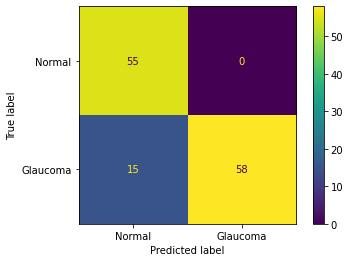

In [ ]:
# make and display a confusion matrix
conf_matrix = confusion_matrix(y_test, preds)

# the display labels come from the condition_dict that assigned 0 to normal eyes and 1 to diseased eyes
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal','Glaucoma']).plot()
# plt.savefig('../presentation/model_performance_images/glauc_conf_matrix.jpg');

In [ ]:
# also generate the classification report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88        55
           1       1.00      0.79      0.89        73

    accuracy                           0.88       128
   macro avg       0.89      0.90      0.88       128
weighted avg       0.91      0.88      0.88       128



### Feature Maps 

Feature maps show what the computer 'sees' after passing a filter over the image. We can look at some of them to gain a better understanding of how the model is processing our images.

We learned how to generate feature maps from [this tutorial on Analytics Vidhya](https://www.analyticsvidhya.com/blog/2020/11/tutorial-how-to-visualize-feature-maps-directly-from-cnn-layers/) and adapted their code to create this section.

Additionally, [this site](https://www.jeremyjordan.me/convolutional-neural-networks/) provides excellent in-depth descriptions and visualizations of how feature maps work.

In [ ]:
# each of the model layer objects can be seen by using model.layers
# these are all the layers we added to the model
model.layers

In [ ]:
# each layer has a name attribute that can be pulled out and saved in a list of layer names
layer_names = [layer.name for layer in model.layers]
layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'conv2d_2',
 'max_pooling2d_2',
 'conv2d_3',
 'max_pooling2d_3',
 'flatten',
 'dense',
 'dense_1',
 'dense_2']

In [ ]:
# each layer also has an output attribute in the form of a keras tensor object. These can also be saved in a list.

# the shapes of the convolutional layer outputs reflect the pixel dimensions 
# and the number of nodes (features) in each layer 
# note that MaxPooling layers cut the dimensions in half - this is becuase of the 2x2 pooling filters

# it is unclear why the dimensions reduce by 2 compared to the inputs.
# for example, the input to the first layer is a 512x512 image, but the layer's output is 510x510.  Puzzling.

layer_outputs = [layer.output for layer in model.layers]
layer_outputs

[<KerasTensor: shape=(None, 510, 510, 16) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, 255, 255, 16) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 253, 253, 32) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 126, 126, 32) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 124, 124, 32) dtype=float32 (created by layer 'conv2d_2')>,
 <KerasTensor: shape=(None, 62, 62, 32) dtype=float32 (created by layer 'max_pooling2d_2')>,
 <KerasTensor: shape=(None, 60, 60, 64) dtype=float32 (created by layer 'conv2d_3')>,
 <KerasTensor: shape=(None, 30, 30, 64) dtype=float32 (created by layer 'max_pooling2d_3')>,
 <KerasTensor: shape=(None, 57600) dtype=float32 (created by layer 'flatten')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'dense')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'dense_1')>,
 <KerasTensor: shape=(None, 1) dtype=float32

In [ ]:
# this is the shape of the input to the model
# it is some number ('None' indicates it can be any number) of 512x512 images with 3 channels (RGB),
# as specified in the model architecture
model.input

<KerasTensor: shape=(None, 512, 512, 3) dtype=float32 (created by layer 'conv2d_input')>

In [ ]:
# instantiate a general keras Model object that lashes up the CNN model's input with the outputs from each of
# the CNN model's layers

# call it feature_map_model

feature_map_model = Model(inputs=model.input, outputs=layer_outputs)
feature_map_model

In [ ]:
# use predict() on feature_map_model to feed it an image and get the CNN model's layers' outputs for that image

# many images could be fed into this, but we're just choosing a single image from X_test at random
# save the predictions as feature_maps
feature_maps = feature_map_model.predict(X_test[120:121])

1/1 [==============================] - 0s 301ms/step


In [ ]:
# note that the shape of the input matches the shape of model.input 
# shape (1, 512, 512, 3) = a single test image (1) that is 512x512 pixels, with 3 channels (RGB)
X_test[120:121].shape

(1, 512, 512, 3)

In [ ]:
# there is just 1 image in feature_maps, so the shape of the feature map in each layer starts with 1
# the 2nd and 3rd numbers in the shape represent the image resolution, which is cut in half at each pooling layer
# the 4th number is the number of nodes in the layer, representing the number of features identified in that layer

# the flatten layer takes the array from the previous layer and turns it into a single dimension -> 
# 62*62*64 = 246016

# the dimensions for the dense and output layers were provided in the model's architecture (256 nodes and 1 node)

for layer_name, feature_map in zip(layer_names, feature_maps):  
    print(f'For the {layer_name} layer, the feature map shape is: {feature_map.shape}')

For the conv2d layer, the feature map shape is: (1, 510, 510, 16)
For the max_pooling2d layer, the feature map shape is: (1, 255, 255, 16)
For the conv2d_1 layer, the feature map shape is: (1, 253, 253, 32)
For the max_pooling2d_1 layer, the feature map shape is: (1, 126, 126, 32)
For the conv2d_2 layer, the feature map shape is: (1, 124, 124, 32)
For the max_pooling2d_2 layer, the feature map shape is: (1, 62, 62, 32)
For the conv2d_3 layer, the feature map shape is: (1, 60, 60, 64)
For the max_pooling2d_3 layer, the feature map shape is: (1, 30, 30, 64)
For the flatten layer, the feature map shape is: (1, 57600)
For the dense layer, the feature map shape is: (1, 256)
For the dense_1 layer, the feature map shape is: (1, 256)
For the dense_2 layer, the feature map shape is: (1, 1)


1/1 [==============================] - 0s 106ms/step


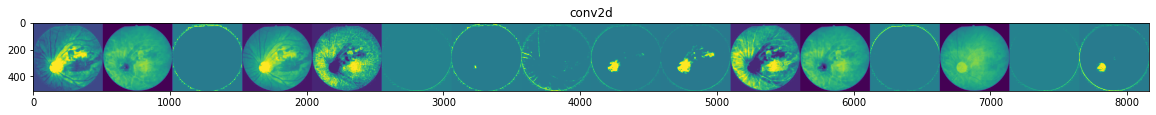

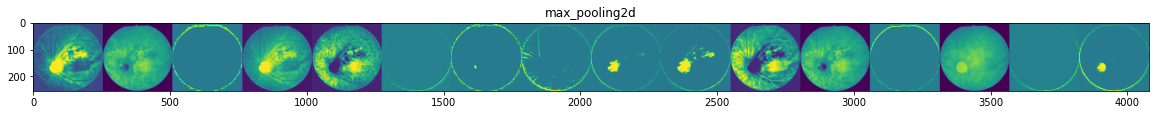

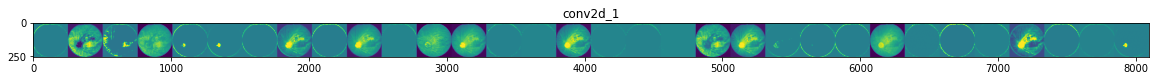

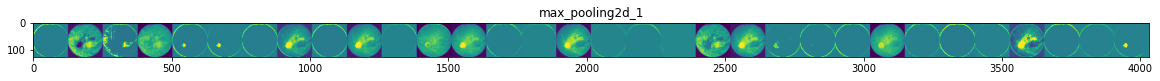

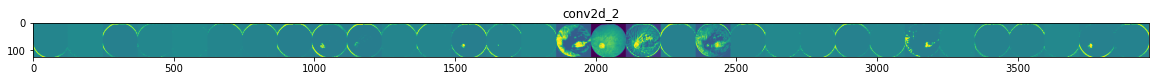

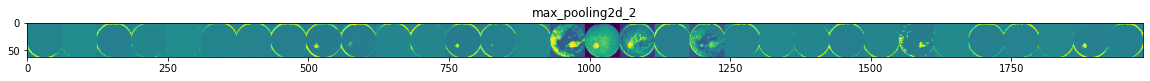

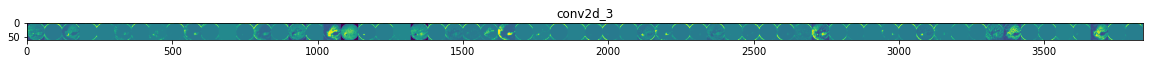

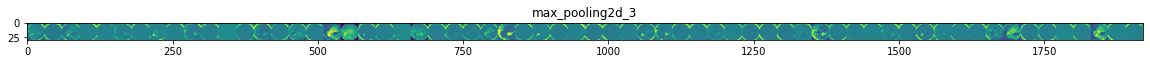

In [ ]:
# the layer_names correspond to the layer names of the model
from keras import models
from PIL import Image
import tensorflow as tf



layer_names = [layer.name for layer in model.layers]

# grab the feature maps for each layer
feature_maps = [layer.output for layer in model.layers]

# create a Keras model that takes in the input image and outputs the feature maps for each layer
activation_model = models.Model(inputs=model.input, outputs=feature_maps)

# load an image to visualize the feature maps
img = Image.open("/content/drive/MyDrive/cleaned_eye_images/glaucoma/1020_left_cleaned.jpg")

# preprocess the image
img = img.resize((512, 512))
x = np.array(img)
x = np.expand_dims(x, axis=0)

# create a tensor from the preprocessed image
img_tensor = tf.convert_to_tensor(x)

# visualize the feature maps for each layer
for layer_name, feature_map in zip(layer_names, activation_model.predict(img_tensor)):
    if len(feature_map.shape) == 4:
        # if the shape is 4D, then the feature map is for a convolutional layer
        n_features = feature_map.shape[-1]  # number of features in the feature map
        size = feature_map.shape[1]  # size of the feature map
        
        # create a grid of plots for the feature maps
        display_grid = np.zeros((size, size * n_features))
        
        # fill the display grid with each feature map
        for i in range(n_features):
            # copy the feature map for the ith feature
            feature_image = feature_map[0, :, :, i]
            
            # normalize the feature image for visualization
            feature_image -= feature_image.mean()
            feature_image /= feature_image.std()
            feature_image *= 64
            feature_image += 128
            feature_image = np.clip(feature_image, 0, 255).astype('uint8')
            
            # place the feature image in the display grid
            display_grid[:, i * size : (i + 1) * size] = feature_image
        
        # plot the feature maps for the layer
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
plt.show()


In [ ]:
# visualize a few of the feature maps from the first convolutional layer


# the 9 layer_names correspond to the 9 feature_maps
for layer_name, feature_map in zip(layer_names, feature_maps):  
    
    # we're just looking at the first convolutional layer, named 'conv2d_3' in this model
    if layer_name=='conv2d_8':
        
        # feature_num is 16, the number of nodes (features) in this layer
        feature_num = feature_map.shape[-1]  

        count=0
        
        # iterate through each of the nodes (features)
        for i in range(feature_num):
            
            # limits the output to 5 images (i.e., stop after looking at 5 nodes (features))
            count+=1
            if count>5:
                break
                
            # this notation copies all of the feature_map array at indexes 1 and 2 (:) and none of index 0 for array i
            # array i represents the node (feature) number. There are 16 of these in the first convolutional layer
            # thus, feature_image has a shape of (510, 510) and holds all the image's feature info for this node 
            feature_image = feature_map[0, :, :, i]
            
            
            # these transformations set the image color mean to 128 and standard deviation to 64
            # the numbers refer to the 256 8-bit colors being used to draw these images
            # by setting the mean and standard deviation, it just makes the color variations easier for us to see
            # for example, when these lines of code are removed, the second outputted image loses a lot of color
            feature_image -= feature_image.mean()
            feature_image /= feature_image.std()
            feature_image *=  64
            feature_image += 128

            # np.clip just ensures all values are in a specified range
            # here, it changes any negatives to 0 and anything over 255 to 255
            # this is so it can be processed as a 256-color image
            # astype('uint8') changes everything to integers for the same reason 
            feature_image = np.clip(feature_image, 0, 255).astype('uint8')
            
            plt.figure()
            
            # imshow can take in an array with 256-color (RGB) values, which is what feature_image now is
            # it takes in the array and produces an image with one pixel for each RGB value
            plt.imshow(feature_image)
            
            # the images can also be saved, per usual savefig() function
            # also re-using count here to give each saved image a different file name
            # commenting out the code so it doesn't keep saving images when this cell is re-run
            #plt.savefig(f'../presentation/feature_maps_filters/eye_feature_map{count}.jpg');
         

### Image Filters
After looking at some of the feature maps, we wanted to also look at some of the filters that went into generating them. We learned about filters and borrowed code from [this post on MachineLearningMastery](https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/). We also looked at [this post on MachineLearningMastery](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/) to deepen our understanding of how filters work.

Filters are developed by the CNN model and are the size specified when the model is being built. We used 3x3 filters in every convolutional layer in our model. Basically, the model examines the input image by sweeping across it with a 3x3 grid (though of course it's looking at numbers, not colors). It then finds patterns that get turned into a filter. The filter weights can be visualized in black and white by translating the weights into a shade of gray. 

Applying the filters to the input image is what ultimately creates the feature maps, explored above.

In [ ]:
# we will look at filters from the first convolutional layer, which is the first layer in our model
model.layers[0]

In [ ]:
# get_weights() returns the filter weights, which are in the first element (the 2nd is the bias weights)
# the filter weights for the first convolutional layer have shape (3,3,3,16)
# this represents 16 filters (the number of nodes (features) for this layer), 3 channels (RGB), and the 3x3 grid size
model.layers[0].get_weights()[0].shape

(3, 3, 3, 16)

In [ ]:
# just looking at some example filter weights
model.layers[0].get_weights()[0][0][0]

array([[-0.00637091, -0.09830508, -0.17095658,  0.15129307,  0.12732282,
         0.13147539, -0.02319382, -0.02666264, -0.12095304, -0.00496196,
        -0.03561014,  0.15886594, -0.12237395,  0.16764338,  0.12758051,
         0.00306557],
       [ 0.10943762,  0.08891481, -0.03396374,  0.1287887 ,  0.01810982,
        -0.08209327,  0.06262341, -0.04008757, -0.18462911, -0.05593763,
        -0.05897551, -0.17788447, -0.10444748,  0.14021316, -0.04637055,
        -0.12255719],
       [-0.1435704 , -0.05583392,  0.15131147,  0.07868569, -0.19305696,
         0.00417349, -0.1287301 , -0.17505789,  0.04873275,  0.01624468,
         0.01021474,  0.15521245, -0.08918821,  0.04310775,  0.14334588,
        -0.11048237]], dtype=float32)

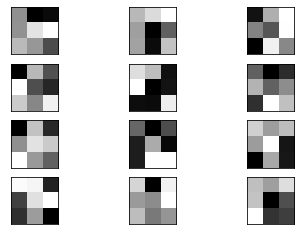

In [ ]:
# visualize some filters from the first convolutional layer

# first, get the weights from the 1st convolutional layer
filters = model.layers[0].get_weights()[0]

# normalize the filter values to 0-1 so we can visualize them
f_min = filters.min()
f_max = filters.max()
filters = (filters - f_min) / (f_max - f_min)

# visualize 4 filters (really 12, since for each of these, there will be one for each RGB channel)
n_filters = 4
image_num = 1

for n in range(n_filters):
    
    # get the filter by grabbing the contents of the first 3 elements of the filter's shape
    f = filters[:, :, :, n]
    
    # plot each RGB channel separately
    for channel in range(3):
        
        # each 3x3 filter will be a subplot. The subplots will be shown in a grid with n_filters rows and 3 columns
        # so each row will be the RGB filters for a single overall filter
        # image_num is the position of the current subplot, starting at 1 and increasing to 12
        # the 4x3 subplot grid has 12 positions, numbered from left to right, top to bottom
        ax = plt.subplot(n_filters, 3, image_num)
        
        # get rid of tick labels, as they don't really make sense in this context
        ax.set_xticks([])
        ax.set_yticks([])
        
        # grab the normalized weights for the channel and plot them by interpreting them as grayscale values
        plt.imshow(f[:, :, channel], cmap='gray')
        
        # move on to the next image position
        image_num += 1

# save the image using savefig
#plt.savefig('../presentation/feature_maps_filters/filter_viz.jpg')

# show the filters
plt.show()


Since these filters are small and were examining a 512x512 image, they're difficult to interpret. However, the hundreds of filters built by the model ultimately give the model the ability to classify the images provided to it with a high degree of accuracy.